# Group F - Written Assignment (small piece of the notebook)

## Stock Indices – Testing for Heteroskedasticity, Multicollinearity, Serial Autocorrelation

**Task:**
- Download monthly data for 10 asset prices and 6 macroeconomic variables, across countries.
- For each index, create a loop where you:
  - Run multivariate OLS regressions using all combinations of 1 and 6 explanatory macroeconomic variables.
  - Save the main regression results to the table.
  - For each regression, test for autocorrelation, heteroskedasticity and multicollinearity, save results into the table.
- The main output table will include the key statistics from each regression as well as the results of the tests.
- Figure out which models have the highest explanatory power and are most promising.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_harvey_collier
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import statistics
import eikon as ek
import sqlite3

## 1. Data Collection and Comparison

**Indices:**
- Switzerland: SMI / SPI
- United States: NASDAQ-100 / S&P 500 
- Germany: DAX / EURO STOXX 50
- United Kingdom: FTSE 100 / FTSE 250 
- Japan: Nikkei 225 / TOPIX 

Overall price data for 10 different indices from 5 different countries are collected.

**Macroeconomic variables:**
- Trade balance
- Unemployment rates
- Consumer Price Index (CPI)
- Retail Sales
- Policy rate (interest rate)
- Consumer Confidence Index (personal saving rate for Switzerland, since CCI is n. a. on monthly basis)

Overall 6 different macroeconomic variables across the 5 above-mentioned countries are collected.

### 1.1 Data Collection from Refinitiv with Excel (Eikon add-in)

#### 1.1.1 Indices

In [4]:
df_indicesExcel = pd.read_csv('Data_Indices.csv')
df_indicesExcel.set_index('Date', inplace=True)
new_headers_indicesExcel = {'NASDAQ-100': 'NASDAQ_100', 'S&P 500': 'SP_500', 'EURO STOXX 50': 'EURO_STOXX_50', 'FTSE 100': 'FTSE_100', 'FTSE 250': 'FTSE_250', 'Nikkei 225': 'Nikkei_225'}
df_indicesExcel.rename(columns=new_headers_indicesExcel, inplace=True)
df_indicesExcel

,SMI,SPI,NASDAQ_100,SP_500,DAX,EURO_STOXX_50,FTSE_100,FTSE_250,Nikkei_225,TOPIX
Date,,,,,,,,,,
12/31/2012,6822.44,6290.52,2660.930,1426.1880,7612.39,2635.93,5897.81,12374.97,10395.18,859.80
1/31/2013,7390.86,6789.40,2731.530,1498.1109,7776.05,2702.98,6276.88,13030.49,11138.66,940.25
2/28/2013,7593.67,7024.53,2738.580,1514.6783,7741.70,2633.55,6360.81,13704.02,11559.36,975.66
3/31/2013,7813.67,7243.46,2818.690,1569.1859,7795.31,2624.02,6411.74,13923.04,12397.91,1034.71
4/30/2013,7906.21,7424.88,2887.440,1597.5657,7913.71,2712.00,6430.12,13949.87,13860.86,1165.13
...,...,...,...,...,...,...,...,...,...,...
11/30/2022,11127.77,14199.52,12030.060,4080.1066,14397.04,3964.72,7573.05,19163.33,27968.99,1985.57
12/31/2022,10729.40,13734.86,10939.762,3839.4966,13923.59,3793.62,7451.74,18853.00,26094.50,1891.71
1/31/2023,11285.78,14490.30,12101.929,4076.6038,15128.27,4163.45,7771.70,19853.45,27327.11,1975.27


#### 1.1.2 Macroeconomic variables

In [5]:
df_macroExcel = pd.read_csv('Data_Macro.csv')
df_macroExcel.set_index('Date', inplace=True)
df_macroExcel

,CH_Trade_Balance,CH_Unemployment,CH_CPI,CH_Retail_Sales,CH_Policy_Rate,CH_Consumer_Confidence,US_Trade_Balance,US_Unemployment,US_CPI,US_Retail_Sales,...,GB_CPI,GB_Retail_Sales,GB_Policy_Rate,GB_Consumer_Confidence,JP_Trade_Balance,JP_Unemployment,JP_CPI,JP_Retail_Sales,JP_Policy_Rate,JP_Consumer_Confidence
Date,,,,,,,,,,,,,,,,,,,,,
12/31/2012,8.780000e+08,3.3,-0.2,4.4,0.25,0.23,-3.633000e+10,7.9,0.0,2.58,...,0.5,1.0,0.50,-29.0,-6.457000e+11,4.3,0.0,0.2,0.1,39.9
1/31/2013,2.008000e+09,3.4,-0.3,1.7,0.25,0.22,-4.014000e+10,8.0,0.2,1.78,...,-0.5,-0.6,0.50,-26.0,-1.633100e+12,4.2,0.1,-1.1,0.1,43.2
2/28/2013,1.931000e+09,3.4,0.3,2.4,0.25,0.21,-4.100000e+10,7.7,0.5,2.56,...,0.7,1.7,0.50,-26.0,-7.733000e+11,4.3,-0.2,-2.2,0.1,44.2
3/31/2013,1.749000e+09,3.2,0.2,-0.4,0.25,0.21,-3.431000e+10,7.5,-0.3,2.89,...,0.3,-1.9,0.50,-26.0,-3.569000e+11,4.1,0.2,-0.3,0.1,44.8
4/30/2013,1.551000e+09,3.1,0.0,2.7,0.25,0.20,-3.849000e+10,7.6,-0.2,2.28,...,0.2,-0.6,0.50,-27.0,-8.774000e+11,4.1,0.3,-0.2,0.1,44.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11/30/2022,2.164000e+09,2.0,0.0,-1.8,0.50,0.05,-6.065000e+10,3.6,0.2,7.77,...,0.4,-0.5,3.00,-44.0,-2.031900e+12,2.5,0.2,2.5,-0.1,29.7
12/31/2022,2.408000e+09,2.1,-0.2,-3.2,1.00,0.10,-6.721000e+10,3.5,0.1,8.09,...,0.4,-1.5,3.50,-42.0,-1.458600e+12,2.5,0.2,3.8,-0.1,31.0
1/31/2023,4.952000e+09,2.2,0.6,-1.7,1.00,0.16,-6.870000e+10,3.4,0.5,4.89,...,-0.6,1.2,3.50,-45.0,-3.506400e+12,2.4,0.5,5.0,-0.1,31.3


In [22]:
indices_df = df_indicesExcel
macro_df = df_macroExcel

## 2. Data Preprocessing

- Using means, standard deviations and number of observations; data.describe()

### 2.1 Data Verification (Outliers, Missing Data, Zeros, n/a or not numerical)

In [23]:
indices_df.describe()

,SMI,SPI,NASDAQ_100,SP_500,DAX,EURO_STOXX_50,FTSE_100,FTSE_250,Nikkei_225,TOPIX
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,9439.925403,10836.119597,7489.389298,2767.862310,11776.954597,3389.901371,6894.328306,18389.953952,20907.496129,1576.368629
std,1316.359106,2559.043066,3857.631833,889.251427,2087.428320,396.388174,524.360800,2434.238455,4802.397203,271.219717
min,6822.440000,6290.520000,2660.930000,1426.188000,7612.390000,2602.590000,5577.270000,12374.970000,10395.180000,859.800000
25%,8456.167500,8694.665000,4340.420500,2062.269150,10024.440000,3112.240000,6508.912500,16715.255000,17349.857500,1389.715000
50%,9066.060000,10387.310000,6488.774000,2644.222950,11914.815000,3394.250000,6957.425000,18573.805000,20652.780000,1579.790000
75%,10319.770000,12752.862500,10947.627000,3294.093425,12992.472500,3601.620000,7331.635000,20057.350000,23384.587500,1795.230000
max,12875.660000,16444.520000,16320.080000,4766.183000,15884.860000,4315.050000,7876.280000,24102.190000,29452.660000,2030.160000


In [24]:
macro_df.describe()

,CH_Trade_Balance,CH_Unemployment,CH_CPI,CH_Retail_Sales,CH_Policy_Rate,CH_Consumer_Confidence,US_Trade_Balance,US_Unemployment,US_CPI,US_Retail_Sales,...,GB_CPI,GB_Retail_Sales,GB_Policy_Rate,GB_Consumer_Confidence,JP_Trade_Balance,JP_Unemployment,JP_CPI,JP_Retail_Sales,JP_Policy_Rate,JP_Consumer_Confidence
count,1.240000e+02,124.000000,124.000000,124.000000,124.000000,124.000000,1.240000e+02,124.000000,124.000000,124.000000,...,124.000000,124.000000,124.000000,124.000000,1.240000e+02,124.000000,124.000000,124.000000,124.000000,124.000000
mean,3.128653e+09,2.870968,0.041129,1.180645,-0.231855,0.077661,-5.034367e+10,5.248387,0.215323,4.734839,...,0.229032,0.196774,0.621774,-13.919355,-4.052855e+11,2.988710,0.083871,0.837097,-0.038710,39.011290
std,1.066642e+09,0.469695,0.265958,5.002271,0.447638,0.063375,1.462519e+10,1.862444,0.289110,4.854119,...,0.450614,2.568665,0.718632,13.310914,8.514438e+11,0.526873,0.307200,3.579378,0.092578,4.928104
min,4.370000e+08,1.900000,-0.600000,-18.400000,-0.750000,0.020000,-1.064400e+11,3.400000,-0.800000,-7.510000,...,-0.900000,-14.500000,0.100000,-49.000000,-3.506400e+12,2.200000,-0.800000,-13.900000,-0.100000,21.800000
25%,2.339250e+09,2.500000,-0.100000,-0.425000,-0.750000,0.030000,-5.948750e+10,3.800000,0.100000,1.975000,...,0.000000,-0.600000,0.250000,-22.250000,-9.257250e+11,2.575000,-0.100000,-0.425000,-0.100000,36.625000
50%,3.070000e+09,3.000000,0.000000,0.700000,-0.250000,0.050000,-4.400500e+10,4.800000,0.200000,3.540000,...,0.200000,0.150000,0.500000,-10.500000,-2.576500e+11,2.900000,0.100000,1.000000,-0.100000,40.650000
75%,3.676750e+09,3.200000,0.200000,2.300000,0.250000,0.092500,-4.014750e+10,6.100000,0.400000,5.580000,...,0.400000,1.025000,0.750000,-5.000000,2.193000e+11,3.400000,0.225000,2.300000,0.100000,42.825000
max,6.035000e+09,3.700000,0.700000,38.200000,1.500000,0.280000,-3.364000e+10,14.700000,1.200000,17.780000,...,2.500000,12.900000,4.250000,7.000000,1.109700e+12,4.300000,2.100000,11.900000,0.100000,45.500000


In [25]:
indices_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124 entries, 12/31/2012 to 3/31/2023
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SMI            124 non-null    float64
 1   SPI            124 non-null    float64
 2   NASDAQ_100     124 non-null    float64
 3   SP_500         124 non-null    float64
 4   DAX            124 non-null    float64
 5   EURO_STOXX_50  124 non-null    float64
 6   FTSE_100       124 non-null    float64
 7   FTSE_250       124 non-null    float64
 8   Nikkei_225     124 non-null    float64
 9   TOPIX          124 non-null    float64
dtypes: float64(10)
memory usage: 10.7+ KB


In [26]:
macro_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124 entries, 12/31/2012 to 3/31/2023
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CH_Trade_Balance        124 non-null    float64
 1   CH_Unemployment         124 non-null    float64
 2   CH_CPI                  124 non-null    float64
 3   CH_Retail_Sales         124 non-null    float64
 4   CH_Policy_Rate          124 non-null    float64
 5   CH_Consumer_Confidence  124 non-null    float64
 6   US_Trade_Balance        124 non-null    float64
 7   US_Unemployment         124 non-null    float64
 8   US_CPI                  124 non-null    float64
 9   US_Retail_Sales         124 non-null    float64
 10  US_Policy_Rate          124 non-null    float64
 11  US_Consumer_Confidence  124 non-null    float64
 12  DE_Trade_Balance        124 non-null    float64
 13  DE_Unemployment         124 non-null    float64
 14  DE_CPI                  124 non-

**Note:** No data is missing in the data frames. The Excel data frame was already cleaned before uploading. In this context, the missing policy rates were filled with the value of the previous month. In addition, the mean value of the previous year was used for the data not yet available for the last month (March 2023).

### 2.2 Visualization of Data

- Plot historical charts for each index as well as macroeconomic variable

In [27]:
indices_df.index = pd.to_datetime(indices_df.index).strftime('%Y')
macro_df.index = pd.to_datetime(macro_df.index).strftime('%Y')

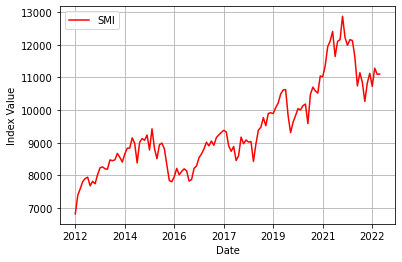

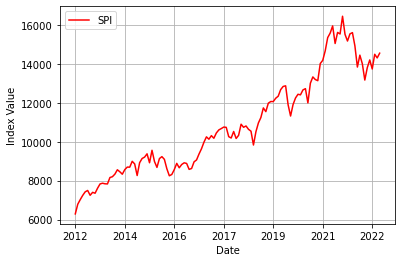

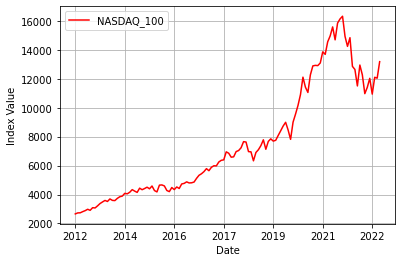

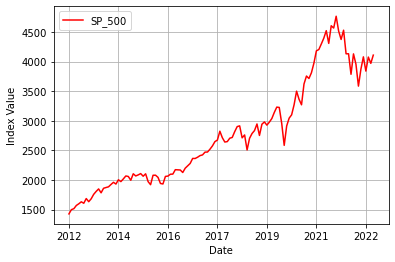

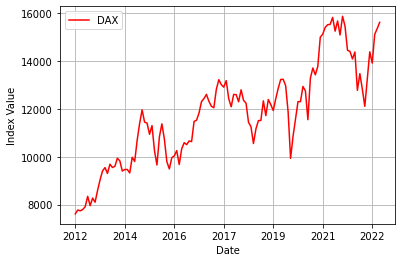

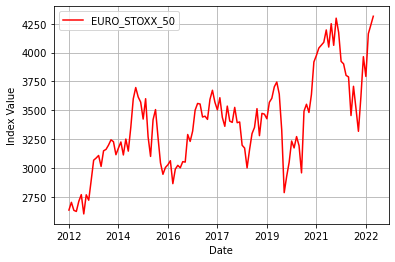

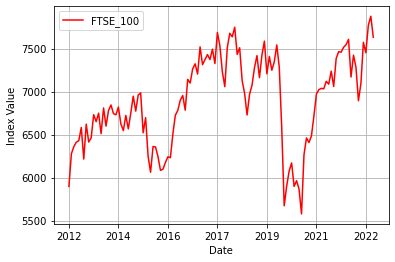

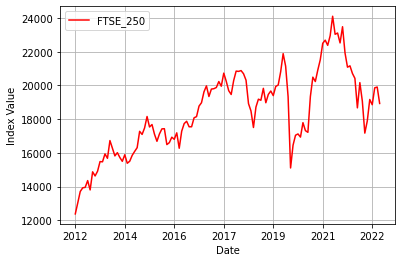

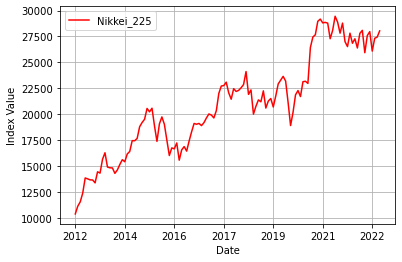

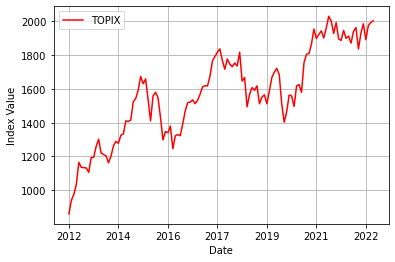

In [28]:
for col in indices_df.columns:
    indices_df.plot(y=[col], grid=True, color='red')
    
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Index Value')
    plt.show()